In [1]:
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import datetime as dt
from math import pi

#Check out what we have
#!dir
#!ls

# Parse JSON Object

Notes about JSON:
* Irregular Objects;
* Every attribute is in a new line;
* Multiple objects in the same file - accounting for data of a single CS:GO map.

As there are couple complications - you cannot simply dump this json directly and trying to put into a list comprehesion  will not work either (due to each object being "spread" in more than one line)

Trying to read with io.pandas will not work either - as it will have its own issues with parsing

In [2]:
data = []

#multiple json objects - formatting so each object lies in a single lie
with open('pro_events_16282_118145.json', 'r') as f:
    treated_object = f.read().replace("\n","").replace("}", "}\n")

#reads - one object per line    
parsed_json =pd.read_json(treated_object, lines=True)

#just for convenience
df = parsed_json

# Explore data - check all columns which were received 

Just a quick glance

In [3]:
#overall columns
display(parsed_json.event.unique())
display(parsed_json.columns)

array(['roundstart', 'attacked', 'kill', 'killassist', 'mvp',
       'roundendscore', 'matchstart', 'threw', 'blinded',
       'plantedthebomb', 'defusedthebomb'], dtype=object)

Index(['armor', 'attackerId', 'attackerTeam', 'attackerX', 'attackerY',
       'attackerZ', 'damage', 'damageArmor', 'datetime', 'event', 'headshot',
       'health', 'hitgroup', 'matchid', 'mode', 'penetrated', 'playerid',
       'reason', 'round', 'team', 'team1', 'team2', 'time', 'type', 'victimId',
       'victimTeam', 'victimX', 'victimY', 'victimZ', 'weapon', 'win', 'x',
       'y', 'z'],
      dtype='object')

# Map Data - External sizes and formatting

Just so it is possible to format it properly accordingly to each coordinate (and then fitting into the 2D map)

**PS**:This .csv was obtained through a kaggle challenge - I have no idea where this came from 

In [4]:
##Map information

#Sets index column to match map names
map_info = pd.read_csv("map_data.csv", index_col = 0)
map_selector = "de_mirage"

#Takes selected map and them filter them out
selected_map = map_info.loc[map_selector]
res_y = selected_map.ResY
res_x = selected_map.ResX
end_y = selected_map.EndY
end_x = selected_map.EndX
start_y = selected_map.StartY
start_x = selected_map.StartX

#As we don't want to keep writing (more) meaningless and repetitive code
def format_x(val_x):
    return (val_x - start_x) * res_x / (end_x - start_x)

def format_y(val_y):
    return (val_y - start_y) * res_y / (end_y - start_y)
    

# Helper methods
This will help us out filtering one event per dataframe

In [5]:
#Will split each event accordingly
def event_splitter(df, event_name):
    df_evt = df[df.event == event_name]
    return df_evt[df_evt.columns[~df_evt.isnull().all()]]


#Just a quick seconds sum method - this will help us out parsing some events between  - pardon-me but I wasn't really planing to write this by hand every time 
def time_sum(time):
    return dt.timedelta(seconds=time)

def num_blind_kill(row, df_ref):
    start_time = row["datetime"]
    end_time = row["final_time"]
    round_n = row["round"]
    flash_victim = row["victimId"]

    killed = df_ref.loc[(df_ref.datetime > start_time) & (df_ref.datetime <= end_time) 
                        & (df_ref.victimId == flash_victim)].shape[0]
    
    return killed


def traded_kill(row, df_ref):
    start_time = row["datetime"]
    end_time = start_time + dt.timedelta(seconds=3)
    killer = row["attackerId"]
    
    traded = df_ref.loc[(df_ref.datetime > start_time) & (df_ref.datetime <= end_time) 
                        & (df_ref.victimId == killer)].shape[0]
    
    return traded

* Format all the coordinate issues beforing normalizing them
* Cut round 0 (we are not using the knife round for this)

In [6]:
df["attackerX"] = df.attackerX.map(format_x)
df["attackerY"] = df.attackerY.map(format_y)
df["victimX"] = df.victimX.map(format_x)
df["victimY"] = df.victimY.map(format_y)

#Round 0 is meaningless
df = df[df["round"] != 0 ]

In [7]:
df_roundstart = event_splitter(df, "roundstart")
df_attacked = event_splitter(df, "attacked")
df_kill = event_splitter(df, "kill")
df_round_end = event_splitter(df, "roundendscore")
df_grenade = event_splitter(df, "threw")
df_blinded = event_splitter(df, "blinded")
df_defusedthebomb = event_splitter(df, "defusedthebomb")
df_plantedthebomb = event_splitter(df, "plantedthebomb")

# Separate the players ID's for each team
display(df_attacked.attackerTeam.unique())
#C is for Counter-terrorists  - T for Terrorists
team_ct = df_attacked.loc[(df_attacked["round"] <= 15) & (df_attacked.attackerTeam == "C")].attackerId.unique()
team_tr = df_attacked.loc[(df_attacked["round"] <= 15) & (df_attacked.attackerTeam == "T")].attackerId.unique()

#Each team MUST have 5 players.
print(team_ct)
print(team_tr)

#blinded setup
df_blinded["final_time"] = df_blinded["datetime"] + df_blinded.time.map(time_sum)
df_blinded["killed"] = df_blinded.apply(num_blind_kill, args=(df_kill,) , axis = 1)

#traded setup
df_kill["traded"] = df_kill.apply(traded_kill, args=(df_kill,) , axis = 1)

array(['C', 'T'], dtype=object)

[ 12362. 107771. 133415.  24134.  28534.]
[7957.  120.  426. 1415.   25.]


In [8]:
#Check first row (or more if you wish to) of data
display(df_attacked.head(1))
display(df_kill.head(1))
display(df_round_end.head(1))
display(df_grenade.head(1))
display(df_blinded.head(1))
display(df_defusedthebomb.head(1))
display(df_plantedthebomb.head(1))

,armor,attackerId,attackerTeam,attackerX,attackerY,attackerZ,damage,damageArmor,datetime,event,health,hitgroup,matchid,round,victimId,victimTeam,victimX,victimY,victimZ,weapon
45,100.0,12362.0,C,203.442386,683.741098,-166.0,100.0,0.0,2019-03-06 23:12:51.363,attacked,0.0,head,16282,1.0,25.0,T,134.563463,719.600236,-168.0,hkp2000


,attackerId,attackerTeam,attackerX,attackerY,attackerZ,datetime,event,headshot,matchid,penetrated,round,victimId,victimTeam,victimX,victimY,victimZ,weapon,traded
46,12362.0,C,203.442386,683.741098,-166.0,2019-03-06 23:12:51.363,kill,1.0,16282,0.0,1.0,25.0,T,134.563463,719.600236,-104.0,usp_silencer,0


,datetime,event,matchid,mode,round,team,team1,team2,win
68,2019-03-06 23:13:15.245,roundendscore,16282,Terrorists_Win,1.0,T,0.0,1.0,2.0


,datetime,event,matchid,playerid,round,type,x,y,z
39,2019-03-06 23:12:42.463,threw,16282,426.0,1.0,flashbang,-1812.0,556.0,573.0


,attackerId,datetime,event,matchid,round,team,time,victimId,final_time,killed
41,1415.0,2019-03-06 23:12:43.096,blinded,16282,1.0,False,3.94,12362.0,2019-03-06 23:12:47.036,0


,datetime,event,matchid,playerid,round
346,2019-03-06 23:21:21.955,defusedthebomb,16282,107771.0,5.0


,datetime,event,matchid,playerid,round
56,2019-03-06 23:13:04.291,plantedthebomb,16282,120.0,1.0


# Sumarize by:

* Player Performance - Each Side
* Number of allies blinded
* Number of Grenades Threw
* Average Blinded Time
* First Kill
* First Death
* Alive 

In [9]:
def number_of_kills(player_id):
    return df_kill.loc[(df_kill.attackerId == player_id) 
                       & (df_kill.attackerTeam != df_kill.victimTeam)
                      & (df_kill.round != 0)].shape[0]


sniper_list = ["awp", "ssg08"]
pistol_list = ["usp_silencer", "glock", "fiveseven", "deagle", "cz75a", "p250", "p2000"]
rifle_list = ["ak47", "m4a1", "m4a4", "aug", "sieg"] #not sure how is sieg


def number_of_kills_weapon(player_id, weapon_list):
    return df_kill.loc[(df_kill.attackerId == player_id) 
                       & (df_kill.attackerTeam != df_kill.victimTeam)
                      & (df_kill.weapon.isin(weapon_list))
                      & (df_kill.round != 0)].shape[0]

def number_of_kills_qota(player_id):
    return df_kill.loc[(df_kill.attackerId == player_id) 
                       & (df_kill.attackerTeam != df_kill.victimTeam)
                      & (df_kill.weapon == "deagle")
                       & (df_kill.headshot == 1)
                      & (df_kill.round != 0)].shape[0]

def number_of_team_kills(player_id):
    return df_kill.loc[(df_kill.attackerId == player_id) 
                  & (df_kill.attackerTeam == df_kill.victimTeam)
                 & (df_kill.round != 0)].shape[0]

def number_of_deaths(player_id):
    return df_kill.loc[(df_kill.victimId == player_id) 
                 & (df_kill.round != 0)].shape[0]


def num_deaths_traded(player_id):
    return df_kill.loc[(df_kill.victimId == player_id) 
                      & (df_kill.round != 0) & (df_kill.traded == 1)].shape[0]


def blinded_team(player_id):
    return df_blinded.loc[(df_blinded.attackerId == player_id) 
                          & df_blinded.team
                         & (df_blinded.round != 0)].shape[0]


def killed_team_blinded(player_id):
    return df_blinded.loc[(df_blinded.attackerId == player_id) 
                      & df_blinded.team
                     & (df_blinded.round != 0)
                     & (df_blinded.killed == 1)].shape[0]


def blinded_enemy_team(player_id):
    return df_blinded.loc[(df_blinded.attackerId == player_id) 
                          & (~ df_blinded.team)
                         & (df_blinded.round != 0)].shape[0]

def killed_enemy_team_blinded(player_id):
    return df_blinded.loc[(df_blinded.attackerId == player_id) 
                      & ~df_blinded.team
                     & (df_blinded.round != 0)
                     & (df_blinded.killed == 1)].shape[0]


#A player can carry/buy up to 4 grenades - being limited to:
# 2 Maximum Flashbangs
# 1 Maximum High Explosive (H.E.) Grenade
# 1 Smoke Grenade 
# 1 Incendiary/Molotov Grenade
# Every grenade plays its own way :
## Flashs often - even if they don't blind, they make enemy retreat, look another way in order to not get blind - creating space
## Smokes isolate "bigger" areas - protecting some specific corners and creating time windows to players cover another spot
## HE deals damage - finishing low health enemy or slowing down rushes
## Molotovs"hard clears" corners - enemies may hold their spot inside a smoke or after being bombed with a HE, but not with molo

# Scores:
###Flash
## +1 for each enemy blinded (2 sec)
## +1.5 for each flash kill assist 
## - 1 for blinded teammate killed
## -0.5 for each teammate blinded (2 sec)
### HE 
##+2 grenade kill
## +1 over .4 damage
### Molotov
## +1 per molotov with 30+ damage
## +1 per kill
### Smoke:
## +1 per Smoke

##Rework on this later - too many repetition funcions 
list_molo = ["molotov", "inferno"]
def grenade_score(player_id):
    ##HE
    he_score_damage = df_attacked[(df_attacked.weapon == "hegrenade") 
                           & (df_attacked.attackerId == player_id) 
                           & (df_attacked.attackerTeam != df_attacked.victimTeam)
                           & (df_attacked.damage >= 40)].shape[0]
    
    he_score = df_kill.loc[(df_kill.attackerId == player_id) 
                       & (df_kill.attackerTeam != df_kill.victimTeam)
                      & (df_kill.weapon == "hegrenade")
                      & (df_kill.round != 0)].shape[0]
    
    ##FLASH
    flash_enemy_killed =  df_blinded.loc[(df_blinded.attackerId == player_id) 
                      & ~df_blinded.team
                     & (df_blinded.round != 0)
                     & (df_blinded.killed == 1)].shape[0]
    
    flash_enemy_blinded =  df_blinded.loc[(df_blinded.attackerId == player_id) 
                      & df_blinded.team
                      & (df_blinded.time >= 2)
                     & (df_blinded.round != 0)
                     & (df_blinded.killed == 0)].shape[0]
    
    flash_teammate_killed =  df_blinded.loc[(df_blinded.attackerId == player_id) 
                      & df_blinded.team
                     & (df_blinded.round != 0)
                     & (df_blinded.killed == 1)].shape[0]
    
    flash_teammate_blinded =  df_blinded.loc[(df_blinded.attackerId == player_id) 
                      & df_blinded.team
                     & (df_blinded.time >= 2)
                     & (df_blinded.round != 0)
                     & (df_blinded.killed == 0)].shape[0]
    
    #Smoke and Molo Count
    smoke_and_molo = df_grenade[(df_grenade.type.isin(["molotov","smokegrenade"])) 
                               & (df_grenade.playerid == player_id)].shape[0]
    
    
    return (2* he_score+he_score_damage 
            + flash_enemy_killed * 1.5 + flash_enemy_blinded 
            - flash_teammate_killed - flash_teammate_blinded * 0.5
            + smoke_and_molo )





In [10]:
#This misses one edgy case - 
all_players = np.append(team_ct,team_tr)

df_test = pd.DataFrame({"playerid": all_players})

df_test["killed"] = df_test.playerid.map(number_of_kills)
df_test["awp_kills"] = df_test.playerid.apply(number_of_kills_weapon, args=(sniper_list,))
df_test["pistol_kills"] = df_test.playerid.apply(number_of_kills_weapon, args=(pistol_list,))
df_test["rifler_kills"] = df_test.playerid.apply(number_of_kills_weapon, args=(rifle_list,))
df_test["qota_kills"] = df_test.playerid.map(number_of_kills_qota)
df_test["team_killed"] = df_test.playerid.map(number_of_team_kills)
df_test["deaths"] = df_test.playerid.map(number_of_deaths)
df_test["deaths_traded"] = df_test.playerid.map(num_deaths_traded)  

df_test["blinded_team"] = df_test.playerid.map(blinded_team)  
df_test["blinded_team_killed"] = df_test.playerid.map(killed_team_blinded)  
df_test["blinded_enemy_team"] = df_test.playerid.map(blinded_enemy_team)  
df_test["blinded_enemy_team_killed"] = df_test.playerid.map(killed_enemy_team_blinded)

df_test["utility_score"] = df_test.playerid.map(grenade_score)


display(df_test)

df_kill.weapon.unique()

,playerid,killed,awp_kills,pistol_kills,rifler_kills,qota_kills,team_killed,deaths,deaths_traded,blinded_team,blinded_team_killed,blinded_enemy_team,blinded_enemy_team_killed,utility_score
0,12362.0,10,1,1,7,0,0,22,3,21,0,36,3,25.5
1,107771.0,27,8,7,12,2,0,21,1,24,1,46,2,25.5
2,133415.0,11,0,2,8,1,0,21,0,16,1,28,2,19.5
3,24134.0,12,0,4,6,1,0,23,3,15,0,23,0,22.5
4,28534.0,13,3,0,9,0,0,19,1,9,0,24,0,16.5
5,7957.0,28,0,5,23,2,0,14,2,7,0,16,1,25.0
6,120.0,15,0,2,13,0,0,14,1,4,0,13,2,38.0
7,426.0,28,1,6,18,0,0,15,1,25,0,47,2,27.5
8,1415.0,17,0,2,14,0,0,15,5,28,0,55,2,31.5
9,25.0,18,12,2,4,0,0,15,3,18,3,56,7,38.5


array(['usp_silencer', 'glock', 'ump45', 'ak47', 'm4a1', 'aug', 'deagle',
       'cz75a', 'ssg08', 'awp', 'mac10', 'fiveseven'], dtype=object)

In [11]:
#kiled
#awper
#rifler
#support/utility_score
#death
#pistol

from sklearn.preprocessing import StandardScaler

selected_columns = ["killed", "deaths", "awp_kills", "rifler_kills", "utility_score"]
scaled_columns  = [elt+ "_scaled" for elt in selected_columns]
tr_team_fst = df_test.loc[df_test.playerid.isin(team_tr)]
tr_team_fst = tr_team_fst.set_index("playerid")
display(tr_team_fst)


scaled_tr =tr_team_fst[selected_columns].div(tr_team_fst[selected_columns].max(axis = 0), axis=1)
display(scaled_tr)




##didnt like the way spider splot has went
# scaler_tr = StandardScaler()

# scaled_tr = tr_team_fst
# scaled_tr[selected_columns] = scaler_tr.fit_transform(tr_team_fst[selected_columns])

# display(scaled_tr[selected_columns])

,killed,awp_kills,pistol_kills,rifler_kills,qota_kills,team_killed,deaths,deaths_traded,blinded_team,blinded_team_killed,blinded_enemy_team,blinded_enemy_team_killed,utility_score
playerid,,,,,,,,,,,,,
7957.0,28,0,5,23,2,0,14,2,7,0,16,1,25.0
120.0,15,0,2,13,0,0,14,1,4,0,13,2,38.0
426.0,28,1,6,18,0,0,15,1,25,0,47,2,27.5
1415.0,17,0,2,14,0,0,15,5,28,0,55,2,31.5
25.0,18,12,2,4,0,0,15,3,18,3,56,7,38.5


,killed,deaths,awp_kills,rifler_kills,utility_score
playerid,,,,,
7957.0,1.000000,0.933333,0.000000,1.000000,0.649351
120.0,0.535714,0.933333,0.000000,0.565217,0.987013
426.0,1.000000,1.000000,0.083333,0.782609,0.714286
1415.0,0.607143,1.000000,0.000000,0.608696,0.818182
25.0,0.642857,1.000000,1.000000,0.173913,1.000000


# Radar Charts Test

 Scraped this from [https://python-graph-gallery.com/radar-chart/] with some minor adaptations

,group,var1,var2,var3,var4,var5
0,A,38.0,29,8,7,28
1,B,1.5,10,39,31,15
2,C,30.0,9,23,33,32
3,D,4.0,34,24,14,14


,playerid,killed,deaths,awp_kills,rifler_kills,utility_score
0,7957.0,1.000000,0.933333,0.000000,1.000000,0.649351
1,120.0,0.535714,0.933333,0.000000,0.565217,0.987013
2,426.0,1.000000,1.000000,0.083333,0.782609,0.714286
3,1415.0,0.607143,1.000000,0.000000,0.608696,0.818182
4,25.0,0.642857,1.000000,1.000000,0.173913,1.000000


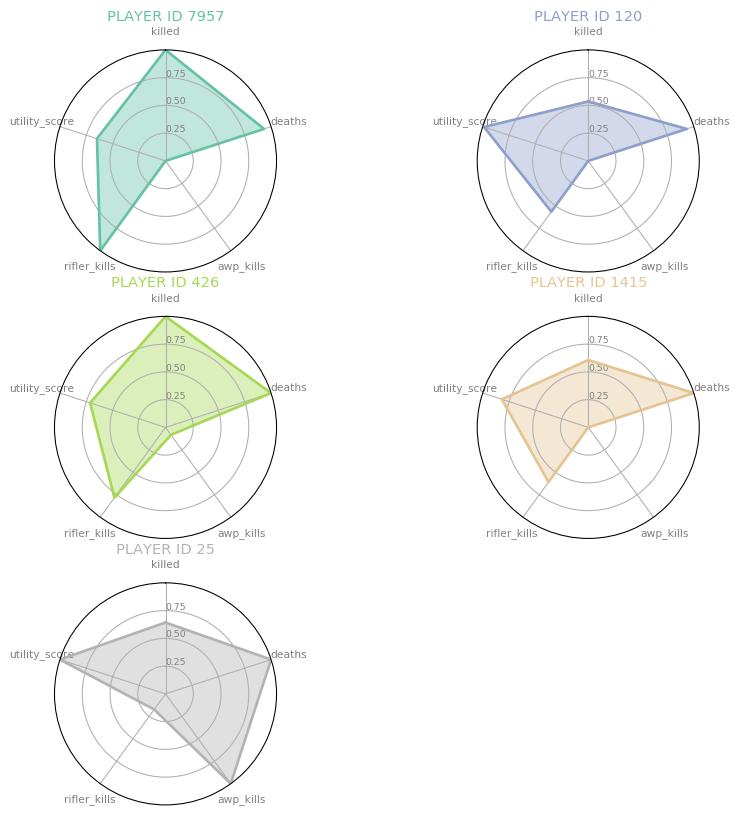

In [12]:
# Set data
df = pd.DataFrame({
'group': ['A','B','C','D'],
'var1': [38, 1.5, 30, 4],
'var2': [29, 10, 9, 34],
'var3': [8, 39, 23, 24],
'var4': [7, 31, 33, 14],
'var5': [28, 15, 32, 14]
})

display(df)
df = scaled_tr.reset_index()
display(df)


def make_spider( row, title, color):
    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3,2,row+1, polar=True, )

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.25,0.50,0.75], ["0.25","0.50","0.75"], color="grey", size=7)
    plt.ylim(0,1)

    # Ind1
    values=df.loc[row].drop('playerid').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)

# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))

# Loop to plot
for row in range(0, len(df.index)):
    make_spider( row=row, title='PLAYER ID '+str(int(df['playerid'][row])), color=my_palette(row))

# Tests with map and coordinates

m:\users\nick\miniconda3\lib\site-packages\matplotlib\patches.py:75: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties.
  warnings.warn("Setting the 'color' property will override"


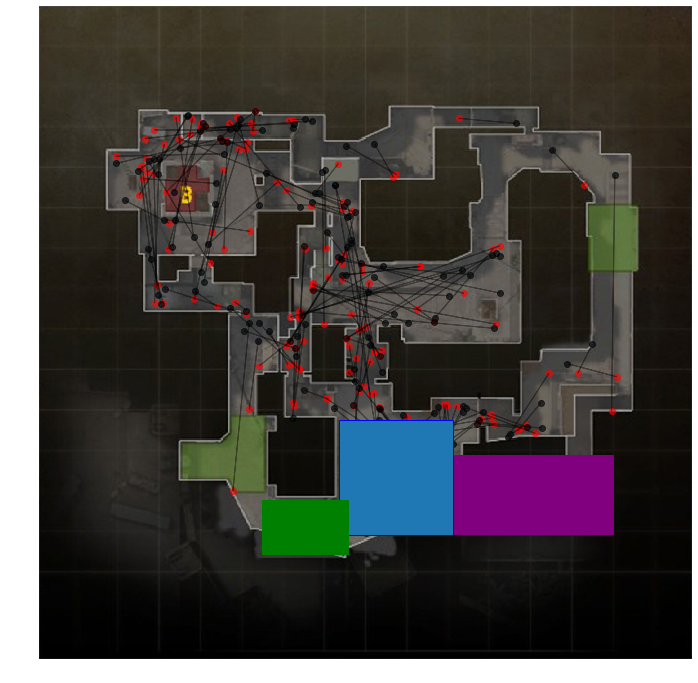

In [13]:
# df_plot = df_kill.loc[(df_kill.victimId == 7957 )&  (df_kill.attackerTeam == "C" )]

df_plot = df_kill



img = plt.imread("mirage.jpg")


fig, ax = plt.subplots(1,1 , figsize=(12,12))
plt.imshow(img, zorder=0, extent=[0.0, 1024, 0., 1024])
plt.axis('off')
plt.scatter(x=df_plot.attackerX, y= df_plot.attackerY, color = "red", alpha = .6)
plt.scatter(x=df_plot.victimX, y= df_plot.victimY, color = "black", alpha = .6)

arrowprops=dict(arrowstyle='<->, head_width=10', facecolor='black')
for index, row in df_plot.iterrows():
    plt.arrow( x= row.attackerX, y = row.attackerY,
              dx= row.victimX - row.attackerX, dy = row.victimY - row.attackerY, alpha = 0.4, head_width =3)

    
import matplotlib.patches as patches
#Rectangle A site - > test


bomb_a = {"x_min": 470, "x_max":650, "y_min": 195, "y_max": 375 }


palacio = {"x_min": 651, "x_max":900, "y_min": 196, "y_max": 320  }
ct_spawn = {"x_min": 350, "x_max":485, "y_min": 165, "y_max": 250  }

bomb_a_rec = patches.Rectangle((bomb_a["x_min"],bomb_a["y_min"]),bomb_a["x_max"] - bomb_a["x_min"], bomb_a["y_max"] - bomb_a["y_min"],linewidth=1,edgecolor='blue',fill=True, zorder =9999)
ax.add_patch(bomb_a_rec)


ct_spawn_rec = patches.Rectangle((ct_spawn["x_min"],ct_spawn["y_min"]),ct_spawn["x_max"] - ct_spawn["x_min"], ct_spawn["y_max"] - ct_spawn["y_min"],linewidth=1,edgecolor='black',fill=True, zorder =9999, color= "green")
ax.add_patch(ct_spawn_rec)

bomb_a_rec = patches.Rectangle((palacio["x_min"],palacio["y_min"]),palacio["x_max"] - palacio["x_min"], palacio["y_max"] - palacio["y_min"],linewidth=1,edgecolor='blue',fill=True, zorder =9999, color="purple")
ax.add_patch(bomb_a_rec)



                                   
plt.show()



In [14]:
df_insight = df_plot.loc[(df_kill.victimId == 7957) & (df_kill.attackerTeam == "C")]


def died_in_area(row, coordinates , team = "T"):
     return df_kill.loc[(df_kill.victimX >= coordinates["x_min"])
                & (df_kill.victimX <= coordinates["x_max"])
                & (df_kill.victimY >= coordinates["y_min"])
                & (df_kill.victimY <= coordinates["y_max"])
                & (df_kill.victimId == row["playerid"]) & (df_kill.victimTeam == team) ].shape[0]

def killed_by_area(row, coordinates , team = "T"):
    return df_kill.loc[(df_kill.attackerX >= coordinates["x_min"])
                & (df_kill.attackerX <= coordinates["x_max"])
                & (df_kill.attackerY >= coordinates["y_min"])
                & (df_kill.attackerY <= coordinates["y_max"])
                & (df_kill.victimId == row["playerid"]) & (df_kill.victimTeam == team) ].shape[0]



df_test["death_bomb_A_tr"] = df_test.apply(died_in_area , args=(bomb_a,"T",) ,axis=1)
df_test["killed_by_ct_spawn"] = df_test.apply(killed_by_area , args=(ct_spawn,"T",) ,axis=1)

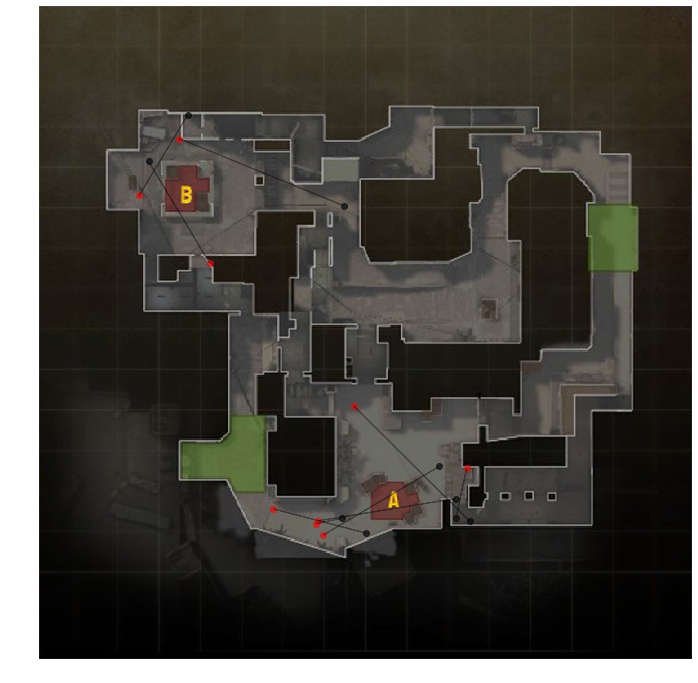

In [15]:
df_insight
img = plt.imread("mirage.jpg")


fig, ax = plt.subplots(1,1 , figsize=(12,12))
plt.imshow(img, zorder=0, extent=[0.0, 1024, 0., 1024])
plt.axis('off')
plt.scatter(x=df_insight.attackerX, y= df_insight.attackerY, color = "red", alpha = .6)
plt.scatter(x=df_insight.victimX, y= df_insight.victimY, color = "black", alpha = .6)

arrowprops=dict(arrowstyle='<->, head_width=10', facecolor='black')
for index, row in df_insight.iterrows():
    plt.arrow( x= row.attackerX, y = row.attackerY,
              dx= row.victimX - row.attackerX, dy = row.victimY - row.attackerY, alpha = 0.4, head_width =3)


In [16]:
df_test = df_test.set_index("playerid")
df_test

,killed,awp_kills,pistol_kills,rifler_kills,qota_kills,team_killed,deaths,deaths_traded,blinded_team,blinded_team_killed,blinded_enemy_team,blinded_enemy_team_killed,utility_score,death_bomb_A_tr,killed_by_ct_spawn
playerid,,,,,,,,,,,,,,,
12362.0,10,1,1,7,0,0,22,3,21,0,36,3,25.5,2,0
107771.0,27,8,7,12,2,0,21,1,24,1,46,2,25.5,1,1
133415.0,11,0,2,8,1,0,21,0,16,1,28,2,19.5,2,0
24134.0,12,0,4,6,1,0,23,3,15,0,23,0,22.5,0,0
28534.0,13,3,0,9,0,0,19,1,9,0,24,0,16.5,0,0
7957.0,28,0,5,23,2,0,14,2,7,0,16,1,25.0,3,4
120.0,15,0,2,13,0,0,14,1,4,0,13,2,38.0,2,1
426.0,28,1,6,18,0,0,15,1,25,0,47,2,27.5,2,0
1415.0,17,0,2,14,0,0,15,5,28,0,55,2,31.5,1,2


In [20]:
display(df_test[["killed","awp_kills","pistol_kills","rifler_kills","deaths","deaths_traded","blinded_team", "blinded_enemy_team", "blinded_enemy_team_killed"]
])

display(df_test.sort_values("killed_by_ct_spawn", ascending = False)[["killed_by_ct_spawn"]])

,killed,awp_kills,pistol_kills,rifler_kills,deaths,deaths_traded,blinded_team,blinded_enemy_team,blinded_enemy_team_killed
playerid,,,,,,,,,
12362.0,10,1,1,7,22,3,21,36,3
107771.0,27,8,7,12,21,1,24,46,2
133415.0,11,0,2,8,21,0,16,28,2
24134.0,12,0,4,6,23,3,15,23,0
28534.0,13,3,0,9,19,1,9,24,0
7957.0,28,0,5,23,14,2,7,16,1
120.0,15,0,2,13,14,1,4,13,2
426.0,28,1,6,18,15,1,25,47,2
1415.0,17,0,2,14,15,5,28,55,2


,killed_by_ct_spawn
playerid,
7957.0,4
1415.0,2
107771.0,1
120.0,1
12362.0,0
133415.0,0
24134.0,0
28534.0,0
426.0,0


# Points:
* Suggest improvements based on performance and behavior on the map
* Suggest general help tips accordingly to each critical point (worst stat)
* Can use rankings (within each team or match) to suggest better playstyles or even to praise the user for its good deeds